In [1]:
import os, warnings, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras import optimizers, Sequential, Model

# Set seeds to make the experiment more reproducible.
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Loading data

In [2]:
df = pd.read_csv('./data/fakta_penjualan_unv_202112091006.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1844679 entries, 0 to 1844678
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   nonota      object 
 1   hari        int64  
 2   bulan       int64  
 3   tahun       int64  
 4   namabarang  object 
 5   satuan      object 
 6   qty         float64
 7   hargajual   float64
 8   hargabeli   float64
 9   hargajual2  float64
 10  kodejenis   object 
 11  jenis       object 
 12  barcode     object 
 13  keuntungan  float64
 14  kodecabang  float64
 15  cabang      float64
dtypes: float64(7), int64(3), object(6)
memory usage: 225.2+ MB


## Drop Column

In [4]:
df = df.drop(['nonota', 'namabarang', 'hargajual', 'hargabeli', 'hargajual2', 'keuntungan', 'kodecabang', 'cabang'], axis=1)

In [5]:
df

,hari,bulan,tahun,satuan,qty,kodejenis,jenis,barcode
0,2,11,2015,PCS,1.00,10304,Hair Care (4),8999999033132
1,2,11,2015,PCS,1.00,10307,Oral Care (7),8999999041953
2,2,11,2015,PCS,5.00,10301,Bath Care (1),8999999045944
3,2,11,2015,PCS,1.00,10307,Oral Care (7),8999999707835
4,2,11,2015,PCS,1.00,10308,Skin Care (8),8999999037918 - 26/06/2020
...,...,...,...,...,...,...,...,...
1844674,10,6,2021,PCS,1.00,3030503,Sikat Gigi (Tooth brush),8999999520137
1844675,10,6,2021,PCS,1.00,3030101,Shampoo,8999999033170
1844676,10,6,2021,PCS,1.00,3030501,Pasta Gigi,8999999037765
1844677,10,6,2021,PCS,1.00,3040201,Sabun Cair,8999999036348


## Examine Unique Symbol from Barcode Column

In [6]:
df['barcode'] = df['barcode'].astype(str).str[:13]
df.head()

,hari,bulan,tahun,satuan,qty,kodejenis,jenis,barcode
0,2,11,2015,PCS,1.00,10304,Hair Care (4),8999999033132
1,2,11,2015,PCS,1.00,10307,Oral Care (7),8999999041953
2,2,11,2015,PCS,5.00,10301,Bath Care (1),8999999045944
3,2,11,2015,PCS,1.00,10307,Oral Care (7),8999999707835
4,2,11,2015,PCS,1.00,10308,Skin Care (8),8999999037918


## Split to Data Test & Data Train

In [7]:
test = df[df['tahun']==2021]
test.head()

,hari,bulan,tahun,satuan,qty,kodejenis,jenis,barcode
1742596,1,1,2021,BTL,1.00,3040201,Sabun Cair,8999999555191
1742597,1,1,2021,PCS,1.00,3040201,Sabun Cair,8999999390198
1742598,1,1,2021,PCS,1.00,3040302,Pembersih Lantai,8999999406929
1742599,1,1,2021,PCS,1.00,3030205,Day Cream,8851932390392
1742600,1,1,2021,PCS,1.00,3030201,Pembersih Wajah,8999999549589


In [8]:
years = [2017, 2018, 2019, 2020]
train = df[df.tahun.isin(years)]
train.head()

,hari,bulan,tahun,satuan,qty,kodejenis,jenis,barcode
412748,1,1,2017,PCS,1.00,10304,Hair Care (4),8999999041144
412749,1,1,2017,BTL,1.00,10308,Skin Care (8),8999999003067
412750,1,1,2017,PCS,1.00,10304,Hair Care (4),8999999033200
412751,1,1,2017,PCS,1.00,10503,Home & Leater Care (3),8999999406950
412752,1,1,2017,PCS,1.00,10502,Detergent (2),8999999006006


## Transform Column to Date Column

In [9]:
def column_to_date(data):
    # create date column from hari, bulan, tahun column
    cols = ["hari","bulan","tahun"]
    data['date'] = data[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
    
    # drop hari, bulan, tahun column
    data = data.drop(['hari', 'bulan', 'tahun'], axis=1)
    
    # transformn date column to datetime
    data['date'] = pd.to_datetime(data['date'])
    
    return data

In [10]:
test = column_to_date(test)
test.head()

,satuan,qty,kodejenis,jenis,barcode,date
1742596,BTL,1.00,3040201,Sabun Cair,8999999555191,2021-01-01
1742597,PCS,1.00,3040201,Sabun Cair,8999999390198,2021-01-01
1742598,PCS,1.00,3040302,Pembersih Lantai,8999999406929,2021-01-01
1742599,PCS,1.00,3030205,Day Cream,8851932390392,2021-01-01
1742600,PCS,1.00,3030201,Pembersih Wajah,8999999549589,2021-01-01


In [11]:
train = column_to_date(train)
train.head()

,satuan,qty,kodejenis,jenis,barcode,date
412748,PCS,1.00,10304,Hair Care (4),8999999041144,2017-01-01
412749,BTL,1.00,10308,Skin Care (8),8999999003067,2017-01-01
412750,PCS,1.00,10304,Hair Care (4),8999999033200,2017-01-01
412751,PCS,1.00,10503,Home & Leater Care (3),8999999406950,2017-01-01
412752,PCS,1.00,10502,Detergent (2),8999999006006,2017-01-01


In [12]:
train['qty'] = train['qty'].astype(int)

## Get month number from Date

In [13]:
# train.sort_values(["date"], ascending=True)

In [14]:
# train['qty'].unique()

In [15]:
# train['date_block_num'] = ((train['date'] - train['date'])/np.timedelta64(1, 'M')).astype(int)

In [16]:
# train = train.drop(['month'], axis=1)

In [17]:
# train['month'] = pd.DatetimeIndex(train['date']).month

In [18]:
# train['month2'] = train['month'].shift().astype(str)

In [19]:
# train["date_block_num_num"] = (train["month_shift_2"] != train["mnth_yr"]).cumsum()
train['month_yr'] = train['date'].apply(lambda x: x.strftime('%m-%y')).astype(str)
# train['month_yr2'] = train['month_yr'].shift().astype(str)
# train['date_block'] = train.groupby(['month_yr', 'month_yr2']).cumsum()

In [20]:
train['month_yr'] = train['month_yr'].map({'01-17':0,'02-17':1,'03-17':2,'04-17':3,'05-17':4,'06-17':5,'07-17':6,'08-17':7,'09-17':8,'10-17':9,'11-17':10,'12-17':11,
                                          '01-18':12,'02-18':13,'03-18':14,'04-18':15,'05-18':16,'06-18':17,'07-18':18,'08-18':19,'09-18':20,'10-18':21,'11-18':22,'12-18':23,
                                          '01-19':24,'02-19':25,'03-19':26,'04-19':27,'05-19':28,'06-19':29,'07-19':30,'08-19':31,'09-19':32,'10-19':33,'11-19':34,'12-19':35,
                                          '01-20':36,'02-20':37,'03-20':38,'04-20':39,'05-20':40,'06-20':41,'07-20':42,'08-20':43,'09-20':44,'10-20':45,'11-20':46,'12-20':47})

In [21]:
display(train)
display(train.info())

,satuan,qty,kodejenis,jenis,barcode,date,month_yr
412748,PCS,1,10304,Hair Care (4),8999999041144,2017-01-01,0
412749,BTL,1,10308,Skin Care (8),8999999003067,2017-01-01,0
412750,PCS,1,10304,Hair Care (4),8999999033200,2017-01-01,0
412751,PCS,1,10503,Home & Leater Care (3),8999999406950,2017-01-01,0
412752,PCS,1,10502,Detergent (2),8999999006006,2017-01-01,0
...,...,...,...,...,...,...,...
1742591,PCS,1,3031201,Sabun Wajah,8999999053031,2020-12-31,47
1742592,BDD,1,3040103,Pelembut Pakaian,8999999057640,2020-12-31,47
1742593,PCS,1,3040302,Pembersih Lantai,8999999407872,2020-12-31,47
1742594,PCS,1,1011114,Saos Cabai (Chili Sauce),8999999530983,2020-12-31,47


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1329848 entries, 412748 to 1742595
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   satuan     1329848 non-null  object        
 1   qty        1329848 non-null  int32         
 2   kodejenis  1329848 non-null  object        
 3   jenis      1329848 non-null  object        
 4   barcode    1329848 non-null  object        
 5   date       1329848 non-null  datetime64[ns]
 6   month_yr   1329848 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(1), object(4)
memory usage: 76.1+ MB


None

In [22]:
train['month_yr'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47],
      dtype=int64)

In [23]:
print(f"Min date from data set: {test['date'].min().date()}")
print(f"Max date from data set: {test['date'].max().date()}")

Min date from data set: 2021-01-01
Max date from data set: 2021-12-05


In [24]:
print(f"Min date from data set: {train['date'].min().date()}")
print(f"Max date from data set: {train['date'].max().date()}")

Min date from data set: 2017-01-01
Max date from data set: 2020-12-31


## Prepare test dataset

Leaving only the barcode that exist in the test set to have more accurate results.
Drop satuan, kodejenis, jenis and date column

In [25]:
test = test.drop(['satuan', 'qty', 'kodejenis', 'jenis', 'date'], axis=1)
test.head()

,barcode
1742596,8999999555191
1742597,8999999390198
1742598,8999999406929
1742599,8851932390392
1742600,8999999549589


In [26]:
# test_shop_ids = test['shop_id'].unique()
# test_item_ids = test['item_id'].unique()
# # Only shops that exist in test set.
# train = train[train['shop_id'].isin(test_shop_ids)]
# # Only items that exist in test set.
# train = train[train['item_id'].isin(test_item_ids)]

test_barcode = test['barcode'].unique()
# Only items that exist in test set.
train = train[train['barcode'].isin(test_barcode)]

## Data preprocessing

- I'm dropping all features but "item_cnt_day" because I'll be using only it as a univariate time-series.
- We are asked to predict total sales for every product and store in the next month, and our data is given by day, so let's aggregate the data by month.
- Also I'm leaving only monthly "item_cnt" >= 0 and <= 20, as this seems to be the distributions of the test set.

In [27]:
display(train.head())
display(train.info())

,satuan,qty,kodejenis,jenis,barcode,date,month_yr
412749,BTL,1,10308,Skin Care (8),8999999003067,2017-01-01,0
412750,PCS,1,10304,Hair Care (4),8999999033200,2017-01-01,0
412752,PCS,1,10502,Detergent (2),8999999006006,2017-01-01,0
412753,PCS,1,10307,Oral Care (7),8999999706180,2017-01-01,0
412754,PCS,1,10301,Bath Care (1),8999999046828,2017-01-01,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1085592 entries, 412749 to 1742595
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   satuan     1085592 non-null  object        
 1   qty        1085592 non-null  int32         
 2   kodejenis  1085592 non-null  object        
 3   jenis      1085592 non-null  object        
 4   barcode    1085592 non-null  object        
 5   date       1085592 non-null  datetime64[ns]
 6   month_yr   1085592 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(1), object(4)
memory usage: 62.1+ MB


None

In [28]:
# train_monthly = train[['date', 'date_block_num', 'shop_id', 'item_id', 'item_cnt_day']]
# train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)
# train_monthly = train_monthly.agg({'item_cnt_day':['sum']})
# train_monthly.columns = ['date_block_num', 'shop_id', 'item_id', 'item_cnt']
# train_monthly = train_monthly.query('item_cnt >= 0 and item_cnt <= 20')
# Label
# train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

# display(train_monthly.head(10).T)
# display(train_monthly.describe().T)

train_monthly = train[['date', 'month_yr', 'satuan', 'kodejenis', 'barcode', 'qty']]
train_monthly = train_monthly.sort_values('date').groupby(['month_yr', 'satuan', 'kodejenis', 'barcode'], as_index=False)
train_monthly = train_monthly.agg({'qty':['sum']})
train_monthly.columns = ['month_yr', 'satuan', 'kodejenis', 'barcode', 'qty_cnt']
train_monthly = train_monthly.query('qty_cnt >= 0 and qty_cnt <= 20')

# Label
train_monthly['qty_cnt_month'] = train_monthly.sort_values('month_yr').groupby(['barcode', 'satuan', 'kodejenis'])['qty_cnt'].shift(-1)

display(train_monthly.head(10))
display(train_monthly.describe())

,month_yr,satuan,kodejenis,barcode,qty_cnt,qty_cnt_month
4,0,BDD,10304,8999999037130,8,9.00
7,0,BDD,10304,8999999048280,8,14.00
11,0,BDD,10506,8999999045616,18,17.00
19,0,BDD,10304,8999999037178,5,14.00
22,0,BDD,10304,8999999048280,9,12.00
25,0,BTL,10103,8992694246173,5,5.00
26,0,BTL,10301,8999999001131,10,9.00
27,0,BTL,10301,8999999001155,1,8.00
28,0,BTL,10301,8999999001162,4,8.00
29,0,BTL,10301,8999999001216,7,13.00


,month_yr,qty_cnt,qty_cnt_month
count,24909.00,24909.00,22292.00
mean,29.19,7.07,7.05
std,15.10,5.58,5.50
min,0.00,0.00,0.00
25%,15.00,2.00,2.00
50%,36.00,5.00,5.00
75%,42.00,11.00,11.00
max,47.00,20.00,20.00


## Time-Series Processing

- As I only need the "item_cnt" feature as a series, I can get that easily by just using a pivot operation.
- This way I'll also get the missing months from each "shop_id" and "item_id", and then replace them with 0 (otherwise would be "nan").

In [29]:
monthly_series = train_monthly.pivot_table(index=['barcode', 'satuan', 'kodejenis'], columns='month_yr',values='qty_cnt', fill_value=0).reset_index()
monthly_series.head()

month_yr,barcode,satuan,kodejenis,0,1,2,3,4,5,6,...,38,39,40,41,42,43,44,45,46,47
0,4800888137319,PCS,10206,4,8,9,8,12,8,15,...,0,0,0,0,0,0,0,0,0,0
1,4800888137319,PCS,3031205,0,0,0,0,0,0,0,...,3,9,4,3,2,0,4,4,6,3
2,4800888137319,PCS,03031205,0,0,0,0,0,0,0,...,0,2,1,0,1,4,0,1,1,0
3,4800888137319,PCS,10206,13,1,1,3,5,0,1,...,0,0,0,0,0,0,0,0,0,0
4,4800888141125,PCS,10206,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Currently I have one series (33 months) for each unique pair of "shop_id" and "item_id", but probably would be better to have multiple smaller series for each unique pair, so I'm generating multiple series of size 12 (one year) for each unique pair

In [30]:
first_month = 34
last_month = 47
serie_size = 12
data_series = []

for index, row in monthly_series.iterrows():
    for month1 in range((last_month - (first_month + serie_size)) + 1):
        serie = [row['barcode'], row['satuan'], row['kodejenis']]
        for month2 in range(serie_size + 1):
            serie.append(row[month1 + first_month + month2])
        data_series.append(serie)

columns = ['barcode', 'satuan', 'kodejenis']
[columns.append(i) for i in range(serie_size)]
columns.append('label')

data_series = pd.DataFrame(data_series, columns=columns)
data_series.head()

,barcode,satuan,kodejenis,0,1,2,3,4,5,6,7,8,9,10,11,label
0,4800888137319,PCS,10206,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4800888137319,PCS,10206,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4800888137319,PCS,3031205,6,7,10,9,3,9,4,3,2,0,4,4,6
3,4800888137319,PCS,3031205,7,10,9,3,9,4,3,2,0,4,4,6,3
4,4800888137319,PCS,03031205,0,0,0,0,0,2,1,0,1,4,0,1,1


## Dropping identifier columns as we don't need them anymore

In [31]:
data_series = data_series.drop(['barcode', 'satuan', 'kodejenis'], axis=1)

## Train and validation sets

In [32]:
labels = data_series['label']
data_series.drop('label', axis=1, inplace=True)
train, valid, Y_train, Y_valid = train_test_split(data_series, labels.values, test_size=0.10, random_state=0)

In [33]:
print("Train set", train.shape)
print("Validation set", valid.shape)
train.head()

Train set (4710, 12)
Validation set (524, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
1718,0,0,0,0,0,0,0,0,0,0,0,0
453,0,0,0,0,0,0,0,0,0,0,0,0
3950,0,0,0,0,0,0,0,0,0,11,20,0
4483,0,14,16,0,0,0,0,0,6,0,0,0
291,0,0,0,0,0,0,0,0,0,0,0,0


## Reshape data.

- Time-series shape (data points, time-steps, features).

In [34]:
X_train = train.values.reshape((train.shape[0], train.shape[1], 1))
X_valid = valid.values.reshape((valid.shape[0], valid.shape[1], 1))

print("Train set reshaped", X_train.shape)
print("Validation set reshaped", X_valid.shape)

Train set reshaped (4710, 12, 1)
Validation set reshaped (524, 12, 1)


## Regular GRU model.

In [35]:
serie_size =  X_train.shape[1] # 12
n_features =  X_train.shape[2] # 1

epochs = 20
batch = 128
lr = 0.0001

lstm_model = Sequential()
lstm_model.add(L.GRU(10, input_shape=(serie_size, n_features), return_sequences=True))
lstm_model.add(L.GRU(6, activation='relu', return_sequences=True))
lstm_model.add(L.GRU(1, activation='relu'))
lstm_model.add(L.Dense(10, kernel_initializer='glorot_normal', activation='relu'))
lstm_model.add(L.Dense(10, kernel_initializer='glorot_normal', activation='relu'))
lstm_model.add(L.Dense(1))
lstm_model.summary()

adam = optimizers.Adam(lr)
lstm_model.compile(loss='mse', optimizer=adam)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 12, 10)            390       
_________________________________________________________________
gru_1 (GRU)                  (None, 12, 6)             324       
_________________________________________________________________
gru_2 (GRU)                  (None, 1)                 27        
_________________________________________________________________
dense (Dense)                (None, 10)                20        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 882
Trainable params: 882
Non-trainable params: 0
__________________________________________________________

In [36]:
lstm_history = lstm_model.fit(X_train, Y_train, 
                              validation_data=(X_valid, Y_valid), 
                              batch_size=batch, 
                              epochs=epochs, 
                              verbose=2)

Epoch 1/20
37/37 - 28s - loss: 24.1867 - val_loss: 27.8465
Epoch 2/20
37/37 - 1s - loss: 24.0741 - val_loss: 27.7094
Epoch 3/20
37/37 - 1s - loss: 23.9362 - val_loss: 27.5441
Epoch 4/20
37/37 - 1s - loss: 23.7711 - val_loss: 27.3459
Epoch 5/20
37/37 - 1s - loss: 23.5756 - val_loss: 27.1098
Epoch 6/20
37/37 - 1s - loss: 23.3417 - val_loss: 26.8316
Epoch 7/20
37/37 - 1s - loss: 23.0659 - val_loss: 26.5025
Epoch 8/20
37/37 - 1s - loss: 22.7353 - val_loss: 26.1185
Epoch 9/20
37/37 - 1s - loss: 22.3468 - val_loss: 25.6523
Epoch 10/20
37/37 - 1s - loss: 21.8845 - val_loss: 25.1018
Epoch 11/20
37/37 - 1s - loss: 21.3366 - val_loss: 24.4488
Epoch 12/20
37/37 - 1s - loss: 20.6913 - val_loss: 23.6722
Epoch 13/20
37/37 - 1s - loss: 19.9227 - val_loss: 22.7770
Epoch 14/20
37/37 - 1s - loss: 19.0433 - val_loss: 21.7443
Epoch 15/20
37/37 - 1s - loss: 18.0594 - val_loss: 20.6335
Epoch 16/20
37/37 - 1s - loss: 17.0483 - val_loss: 19.5051
Epoch 17/20
37/37 - 1s - loss: 16.0616 - val_loss: 18.5006
Epoch

###### Model training

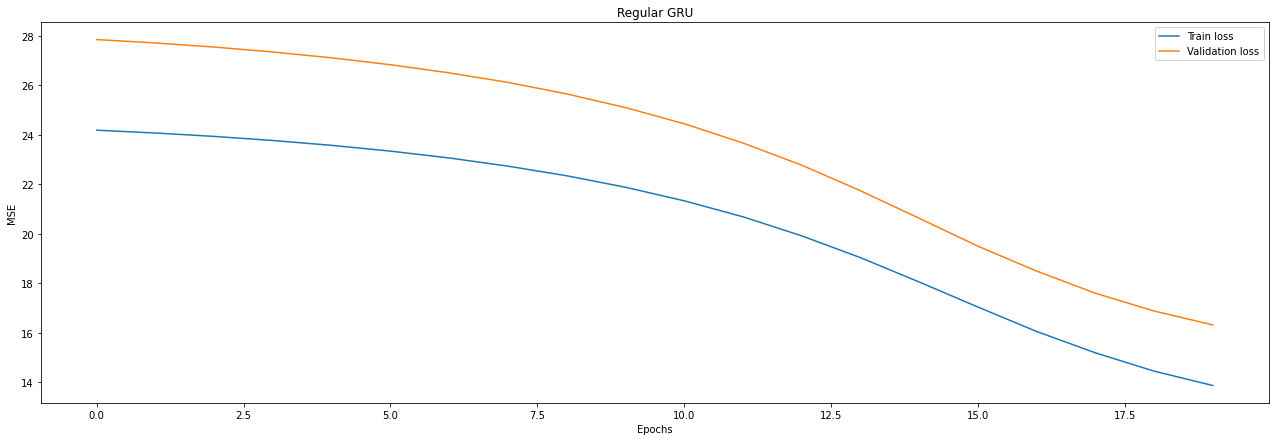

In [37]:
fig, ax1 = plt.subplots(1, sharey=True,figsize=(22,7))

ax1.plot(lstm_history.history['loss'], label='Train loss')
ax1.plot(lstm_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Regular GRU')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

plt.show()

##### Regular GRU on train and validation

In [38]:
lstm_train_pred = lstm_model.predict(X_train)
lstm_val_pred = lstm_model.predict(X_valid)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_val_pred)))

Train rmse: 3.6915750627231123
Validation rmse: 4.040487909563424


##### Build test set
Since we have two models I'll build test sets to apply on both of them.

In [39]:
latest_records = monthly_series.drop_duplicates(subset=['barcode', 'satuan', 'kodejenis'])
X_test = pd.merge(test, latest_records, on=['barcode'], how='left', suffixes=['', '_'])
X_test.fillna(0, inplace=True)
X_test.drop(['barcode', 'satuan', 'kodejenis'], axis=1, inplace=True)
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,14.00,18.00,10.00,15.00,12.00,5.00,2.00,6.00,7.00,6.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1.00,1.00,0.00,1.00,2.00,14.00,6.00,1.00,0.00,2.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,18.00,0.00,15.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,12.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,19.00,0.00,0.00,0.00,0.00


##### Regular LSTM model test predictions
- For the regular LSTM model we just need the last 12 months, because that's our series input size.

In [40]:
X_test = X_test[[(i + (48 - serie_size)) for i in range(serie_size)]]
X_test.head()

,36,37,38,39,40,41,42,43,44,45,46,47
0,6.00,4.00,14.00,18.00,10.00,15.00,12.00,5.00,2.00,6.00,7.00,6.00
1,2.00,1.00,1.00,1.00,0.00,1.00,2.00,14.00,6.00,1.00,0.00,2.00
2,0.00,0.00,18.00,0.00,15.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,19.00,0.00,0.00,0.00,0.00


##### Reshape data.
- Time-series shape (data points, time-steps, features).

In [41]:
X_test_reshaped = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
print(X_test_reshaped.shape)

(258757, 12, 1)


##### Making predictions.

In [42]:
lstm_test_pred = lstm_model.predict(X_test_reshaped)

##### Predictions from the regular GRU model.

In [43]:
lstm_test_pred

array([[4.745269 ],
       [3.5327864],
       [2.0433784],
       ...,
       [0.9005468],
       [0.9005468],
       [4.3178883]], dtype=float32)

In [44]:
lstm_prediction = pd.DataFrame(test['barcode'], columns=['barcode'])
lstm_prediction['item_cnt_month'] = lstm_test_pred.clip(0., 20.)
# lstm_prediction.to_csv('gru_submission.csv', index=False)
lstm_prediction.head(10)

ValueError: Length of values (258757) does not match length of index (102083)